<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Read synthetic population data**

In [73]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_people = 'franklin/microdata/franklin_peoplev0.csv'
data_people = pd.read_csv(filename_people)
data_people['GEOID10'] = data_people['GEOID10'].astype(str)
data_people['BGID10'] = data_people['GEOID10'].str[:12]
data_people['TRACTID10'] = data_people['GEOID10'].str[:11]
data_people

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,GEOID10,PUMAID,SEX,RAC1P,AGEP,DIS,MSP,MIG,MIL,SCHL,FOD1P,HICOV,PRIVCOV,PUBCOV,PINCP,POVPIP,COW,ESR,SOCP,JWMNP,JWRIP,JWTRNS,HouseholdID,lon,lat,BGID10,TRACTID10
0,390490001101001,3904102,1,1,26,2,6.0,3.0,4.0,19.0,NaN,2,2,2,25000.0,495.0,6.0,1.0,1191XX,5.0,1.0,1.0,1,-82.999368,40.054253,390490001101,39049000110
1,390490001101001,3904102,2,9,26,2,6.0,3.0,4.0,19.0,NaN,1,1,2,20000.0,162.0,1.0,1.0,37201X,5.0,2.0,1.0,1,-82.999368,40.054253,390490001101,39049000110
2,390490001101002,3904102,2,1,1,2,NaN,3.0,NaN,NaN,NaN,2,2,2,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4,-83.002695,40.060864,390490001101,39049000110
3,390490001101002,3904102,2,1,4,2,NaN,1.0,NaN,2.0,NaN,1,1,2,NaN,501.0,NaN,NaN,NaN,NaN,NaN,NaN,5,-83.001629,40.060899,390490001101,39049000110
4,390490001101002,3904102,2,1,8,2,NaN,1.0,NaN,4.0,NaN,1,1,2,NaN,491.0,NaN,NaN,NaN,NaN,NaN,NaN,6,-83.001937,40.060852,390490001101,39049000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138714,390490107001020,3904102,2,1,77,1,3.0,1.0,4.0,19.0,NaN,1,2,1,17200.0,144.0,NaN,6.0,NaN,NaN,NaN,NaN,70,-83.017831,40.065591,390490107001,39049010700
1138715,390490107001020,3904102,1,1,94,2,1.0,1.0,2.0,22.0,5200.0,1,1,1,5200.0,266.0,NaN,6.0,NaN,NaN,NaN,NaN,108,-83.017814,40.062582,390490107001,39049010700
1138716,390490107001020,3904102,2,1,94,1,6.0,1.0,4.0,16.0,NaN,1,2,1,0.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,95,-83.018259,40.064492,390490107001,39049010700
1138717,390499800001027,3904106,1,1,74,2,2.0,1.0,4.0,15.0,NaN,1,1,1,33300.0,221.0,NaN,6.0,NaN,NaN,NaN,NaN,1,-82.879433,40.004085,390499800001,39049980000


#### **Create original histograms**
We consider the query of race (RAC1P) for the purpose of demonstration. Cell uniqueness is presented in this query.

In [74]:
hist1 = pd.crosstab(data_people.GEOID10, data_people.RAC1P)
hist1

RAC1P,1,2,3,4,5,6,7,8,9
GEOID10,,,,,,,,,
390490001101001,1,0,0,0,0,0,0,0,1
390490001101002,45,0,0,0,0,0,0,0,0
390490001101003,51,4,0,0,0,0,0,0,0
390490001101004,48,0,0,0,0,0,0,0,0
390490001101005,51,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...
390490107001015,92,17,0,0,0,0,0,1,2
390490107001016,9,0,0,0,0,0,0,0,0
390490107001017,42,6,0,0,0,9,0,0,0


[(0.0, 10.0)]

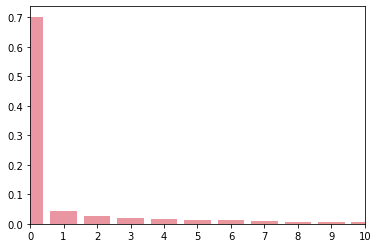

In [75]:
import seaborn as sns

probabilities = hist1.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

#### **Add noises (Zero-concentrated differential privacy)**
There are two core components to the 2020 DAS: noise injection and post-processing. We only focus on the noise injection here. Consistent with the 2020 DAS, discrete Gaussian noise is applied.

Bun, M., & Steinke, T. (2016, November). Concentrated differential privacy: Simplifications, extensions, and lower bounds. In Theory of Cryptography Conference (pp. 635-658). Springer, Berlin, Heidelberg.

Parameters for generating Gaussian noise.

In [76]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0

(0.03765194044422748, 1.8998742342553376)

Probability of generating zero noise and other noises.

In [77]:
import scipy.stats

print(scipy.stats.norm(0, sigma).cdf(0.5) - scipy.stats.norm(0, sigma).cdf(-0.5), 
      scipy.stats.norm(0, sigma).cdf(1.5) - scipy.stats.norm(0, sigma).cdf(0.5),
      scipy.stats.norm(0, sigma).cdf(2.5) - scipy.stats.norm(0, sigma).cdf(1.5),
      scipy.stats.norm(0, sigma).cdf(3.5) - scipy.stats.norm(0, sigma).cdf(2.5), 
      scipy.stats.norm(0, sigma).cdf(8.5) - scipy.stats.norm(0, sigma).cdf(7.5))

0.10913342502468493 0.1051255079831912 0.09396346340685724 0.07793101600369479 0.009953116866908474


Add noise to histogram.

In [78]:
hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
hist2

RAC1P,1,2,3,4,5,6,7,8,9
GEOID10,,,,,,,,,
390490001101001,3.0,2.0,4.0,1.0,-1.0,-1.0,2.0,0.0,5.0
390490001101002,47.0,-3.0,2.0,-8.0,6.0,4.0,-2.0,5.0,4.0
390490001101003,50.0,7.0,-1.0,9.0,8.0,1.0,0.0,-5.0,1.0
390490001101004,52.0,0.0,1.0,-2.0,6.0,4.0,2.0,8.0,7.0
390490001101005,55.0,-1.0,10.0,-2.0,-4.0,-2.0,-1.0,-5.0,7.0
...,...,...,...,...,...,...,...,...,...
390490107001015,91.0,18.0,-7.0,-6.0,-2.0,-3.0,-1.0,0.0,4.0
390490107001016,13.0,-2.0,-10.0,1.0,-3.0,-1.0,-1.0,0.0,0.0
390490107001017,41.0,9.0,-1.0,4.0,-2.0,11.0,-6.0,-2.0,-1.0


####**Cell uniqueness**
Young, C., Martin, D., & Skinner, C. (2009). Geographically intelligent disclosure control for flexible aggregation of census data. International Journal of Geographical Information Science, 23(4), 457-482.

Privacy measure: probability of finding a true unique

In [79]:
# find a true unique
tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
n_tu

653

In [80]:
# uniques after noise injection
u = hist2 == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
n_u

11652

In [81]:
# frequency of finding the true uniques
p_tu = n_tu / n_u
p_tu

0.05604188122210779

Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

$p(TU)=\frac{p(-0.5<=W<=0.5)p(A_1)}{\sum_ip(0.5-i<=W<=1.5-i)p(A_i)}$


$p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [64]:
import scipy.stats

column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.054544768415419304

We also use a Monte Carlo method to calculate the expected frequency (probability) of finding the true uniques. The result is consistent with the theoretical value.

In [65]:
import statistics
import numpy as np

N = 1000    # bootstrap times
p_tus = []

for i in range(N):
    hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
    # find a true unique
    tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2 == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu = n_tu / n_u
    p_tus.append(p_tu)

statistics.mean(p_tus)

0.05450878379766212

####**More on cell uniqueness**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.

#####**Impact of resolutions (aggregation levels)**
We test the probability of finding a true unique at both block group and tract levels. As shown below, as we increase the aggregation level, the probability raises. This is potentially due to the fact that the histogram is less clustered around the small numbers (e.g., 2, 3, 0 that are easily transformed to 1 when adding noises).

Block group.

In [82]:
hist1_bg = pd.crosstab(data_people.BGID10, data_people.RAC1P)
hist1_bg

RAC1P,1,2,3,4,5,6,7,8,9
BGID10,,,,,,,,,
390490001101,1040,14,0,0,0,8,0,3,15
390490001102,814,15,0,0,0,14,0,2,7
390490001103,619,6,0,0,0,4,0,6,9
390490001104,744,5,0,0,0,4,0,1,5
390490001201,758,6,0,0,0,10,0,1,12
...,...,...,...,...,...,...,...,...,...
390490106021,1369,46,0,0,0,39,0,15,23
390490106022,2293,58,0,0,0,154,0,14,41
390490106023,1824,50,0,0,0,209,0,18,35


[(0.0, 10.0)]

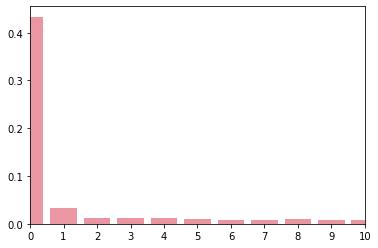

In [83]:
import seaborn as sns

probabilities = hist1_bg.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [67]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 3/4099

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0

(0.012544523054403513, 1.0874367368840445)

In [68]:
import scipy.stats

column_values = hist1_bg[hist1_bg.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.06184121453803658

Tract.

In [31]:
hist1_tr = pd.crosstab(data_people.TRACTID10, data_people.RAC1P)
hist1_tr

RAC1P,1,2,3,4,5,6,7,8,9
TRACTID10,,,,,,,,,
39049000110,3217,40,0,0,0,30,0,12,36
39049000120,3016,44,0,0,1,36,0,6,48
39049000210,2773,51,1,0,0,26,0,8,62
39049000220,3536,31,0,0,0,50,0,20,76
39049000310,2135,739,0,0,0,67,0,55,137
...,...,...,...,...,...,...,...,...,...
39049010500,6499,100,0,0,0,1178,0,28,115
39049010601,3933,127,0,0,0,436,0,30,83
39049010602,5486,154,0,0,0,402,0,47,99


[(0.0, 10.0)]

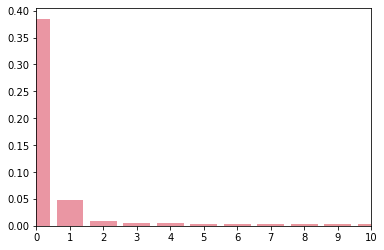

In [ ]:
import seaborn as sns

probabilities = hist1_tr.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [69]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 4/2051

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0

(0.03342759629449049, 1.7880772470489288)

In [70]:
import scipy.stats

column_values = hist1_tr[hist1_tr.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.109321997384347

#####**Impact of extents**

Read block and tract data.

In [ ]:
!pip install geopandas
!pip install pysal

In [91]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block['GEOID10'] = data_block['GEOID10'].astype(str)
data_block['BGID10'] = data_block['GEOID10'].str[:12]
data_block['TRACTID10'] = data_block['GEOID10'].str[:11]
data_block.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID_1', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
       'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'PUMA',
       'Shape_Length', 'Shape_Area', 'BGID10', 'TRACTID10', 'geometry'],
      dtype='object')

In [112]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract = 'franklin/buildings/franklin_tract10.json'
data_tract = gpd.read_file(filename_tract)
data_tract['GEOID10'] = data_tract['GEOID10'].astype(str)
data_tract.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

Find blocks in the most populated tract (largest population density).

In [98]:
total = hist1_tr.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])
total.head()

,POP,GEOID10
39049000110,3335,39049000110
39049000120,3151,39049000120
39049000210,2921,39049000210
39049000220,3713,39049000220
39049000310,3133,39049000310


In [110]:
data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(232, '39049001810')

Calculate $p(TU)$ based on the selected blocks (only blocks in the most population tract).

In [101]:
data_people_b1 = data_people[data_people["TRACTID10"] == max_id]
hist1_b1 = pd.crosstab(data_people_b1.GEOID10, data_people_b1.RAC1P)
hist1_b1.head()

RAC1P,1,2,3,5,6,8,9
GEOID10,,,,,,,
390490018101000,88,5,0,0,7,2,4
390490018101001,45,0,0,0,8,0,1
390490018101002,338,25,0,0,53,6,15
390490018101003,153,4,0,0,30,0,5
390490018101004,234,7,0,0,40,0,6


[(0.0, 10.0)]

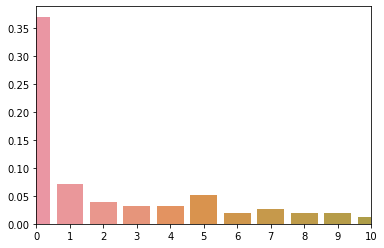

In [102]:
import seaborn as sns

probabilities = hist1_b1.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [103]:
import scipy.stats

column_values = hist1_b1[hist1_b1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_b1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_b1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.12633160521910972

Expand the examined blocks by considering those in the k-nearst neighbors of the most populated tract.

In [125]:
import geopandas as gpd
from pysal.lib import weights

k5 = weights.KNN.from_dataframe(data_tract, k=5)
nb_index = k5.neighbors[max_index]
nb_id = data_tract["GEOID10"].iloc[nb_index]
nb_id

231    39049001820
126    39049001121
233    39049001700
230    39049002000
244    39049001300
Name: GEOID10, dtype: object

In [126]:
data_people_b2 = data_people[data_people["TRACTID10"].isin(nb_id)]
hist1_b2 = pd.crosstab(data_people_b2.GEOID10, data_people_b2.RAC1P)
hist1_b2.head()

RAC1P,1,2,3,5,6,8,9
GEOID10,,,,,,,
390490011212001,5,1,0,0,0,0,0
390490011212003,1779,90,0,2,125,16,5
390490011213000,13,0,0,0,10,0,1
390490011213001,11,0,0,0,4,0,1
390490011213002,36,1,0,0,0,0,0


[(0.0, 10.0)]

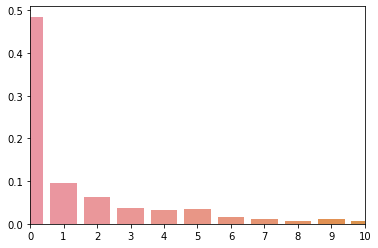

In [127]:
import seaborn as sns

probabilities = hist1_b2.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [128]:
import scipy.stats

column_values = hist1_b2[hist1_b2.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_b2 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_b2 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.13538124078773764

We can keep searching the k-neighbors until all blocks in the county are covered. 

In [167]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.KNN.from_dataframe(data_tract, k=10)

tract_index = [max_index]
p_tu_all = []
while len(tract_index) < len(data_tract):
    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    data_people_sub = data_people[data_people["TRACTID10"].isin(tract_ids)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.RAC1P)
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all.append(p_tu)

    # add neighbors 
    nb_index = np.array([k10.neighbors.get(tract) for tract in tract_index]).flatten()
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_all

[0.12633160521910972,
 0.142613659839094,
 0.12191766888618107,
 0.08939383684202645,
 0.07462288610627751,
 0.0708886671197483,
 0.05880320127166395,
 0.05653310155035756,
 0.05631255893117945,
 0.05549527302405874,
 0.05480016528592121]

We visualize the trend of $p(TU)$ during the expansion. As shown in the figure, $p(TU)$ increases in the first iteration, and then continues to decrease during the subsequent interations.

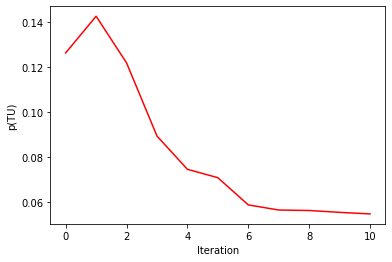

In [169]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_all), color = 'r')
plt.xlabel("Iteration")
plt.ylabel("p(TU)")
plt.show()

The trend above can potentially be explained by the population distribution in the county. During the first iteration, more populated blocks are added in the histogram, and thus it is less concentrated around small numbers. As the iteration increases, more sparse blocks are added, and the histogram is more concentrated around zero. This can lead to the sharpe decrease in $p(TU)$.

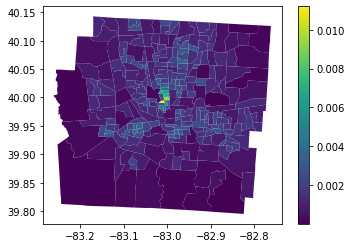

In [170]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
data_tract_new.plot(column='POP_DEN', ax=ax, legend=True)

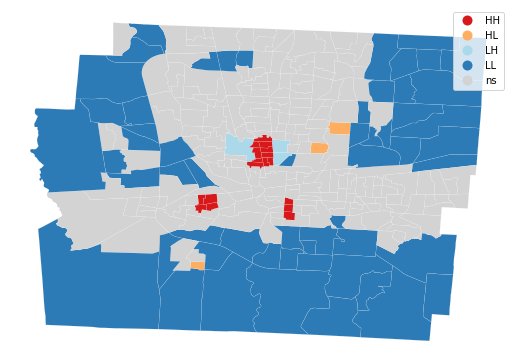

In [171]:
from splot.esda import lisa_cluster
from pysal.lib import weights
from pysal.explore import esda

data_tract_new['POP_DEN'] = data_tract_new['POP_DEN'].fillna(0)
# Generate W from the GeoDataFrame
w = weights.Queen.from_dataframe(data_tract_new)
# Row-standardization
w.transform = 'R'

moran_loc = esda.moran.Moran_Local(data_tract_new['POP_DEN'].values, w)
lisa_cluster(moran_loc, data_tract_new, p=0.05, figsize = (9,9))
plt.show()

####**Check LP metric**
Wieland, S. C., Cassa, C. A., Mandl, K. D., & Berger, B. (2008). Revealing the spatial distribution of a disease while preserving privacy. Proceedings of the National Academy of Sciences, 105(46), 17608-17613.

Privacy measure: probability that any chosen member of the population belong to the target population